# Encuestas Wikipedia

Haciendo web scrapping de https://es.wikipedia.org/wiki/Anexo:Encuestas_de_intenci%C3%B3n_de_voto_para_las_elecciones_presidenciales_de_Argentina_de_2023

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

In [2]:
URL = "https://es.wikipedia.org/wiki/Anexo:Encuestas_de_intenci%C3%B3n_de_voto_para_las_elecciones_presidenciales_de_Argentina_de_2023"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

In [3]:
encabezado = ['Fecha',
              'Encuestadora',
              'Muestra',
              'Union por la Patria',
              'Juntos por el Cambio', 
              'La Libertad Avanza',
              'Hacemos juntos nuestro Pais', 
              'Frente de Izquierda y Trabajadores',
              'Otros',
              'Blanco',
              'Indecisos',
              'Ventaja']

In [4]:
tabla1 = soup.find('table',class_ = "wikitable")

In [5]:
dicc_mes = {
    'enero': "01",
    'febrero': "02",
    'marzo': "03",
    'abril': "04",
    'mayo': "05",
    'junio': "06",
    'julio': "07",
    'agosto': "08",
    'septiembre': "09",
    'octubre': "10",
    'noviembre': "11",
    'diciembre': "12"
    }

In [6]:
def inicio(strr):
    anio = 2023
    # mes = 11
    separado = strr.split('-')
    aux =  separado[0].split(' ')
    if len(aux)<=2:
        dia = int(aux[0])
        aux_mex = separado[1].split(' ')
        if len(aux_mex)==6:
            aux_mex = aux_mex[1:]
        if len(aux_mex)==5:
            mes = int(dicc_mes[aux_mex[2].lower()])
            anio  = int(aux_mex[4])
    elif len(aux)==3:
        dia = 1
        mes = int(dicc_mes[aux[0].lower()])
        anio = int(aux[2])
    elif len(aux)==4:
        dia = int(aux[0])
        mes = int(dicc_mes[aux[2].lower()])
    elif len(aux)==5:
        dia = int(aux[0])
        mes = int(dicc_mes[aux[2].lower()])
        try:
            anio = int(aux[4])
        except:
            pass 
    elif len(aux)==6:
        dia = int(aux[0])
        mes = int(dicc_mes[aux[2].lower()])
        anio = int(aux[4])

    return datetime.datetime(anio,mes,dia)  


In [7]:
def final(strr):
    separado = strr.split('-')
    
    if len(separado)==1:
        res =  inicio(separado[0])
    elif len(separado)==2:
        aux =  separado[1].split(' ')
        if len(aux)==6 or aux[0]=='':
            aux = aux[1:]
        if len(aux)==5:
            dia = int(aux[0])
            mes = int(dicc_mes[aux[2].lower()])
            anio  = int(aux[4])
        if len(aux)==4:
            dia = int(aux[0])
            mes = int(dicc_mes[aux[1].lower()])
            anio  = int(aux[3])
        
        res = datetime.datetime(anio,mes,dia)  
    
    return res

In [8]:
def obtener_DF(tabla,encabezado):
    filas_pagina = tabla.find_all('tr')

    filas = []
    for i,fila in enumerate(filas_pagina):
        lista_fila = []
        col = fila.find_all('td')

        for c in col:
            lista_fila.append(c.text.strip())
        
        if len(lista_fila)==(len(encabezado)-3):
            #si la lista es 3 veces mas corta que el encabezado, se añade la misma info faltante que la ultima fila 
            aux = filas[-1]
            filas.append(aux[:3]+lista_fila)
        elif len(lista_fila)==len(encabezado):
            # si el largo coincide con la cant. atributos, se guarda
            filas.append(lista_fila)
        else:
            # Casos diferente no se agrega para evitar errores en la construccion de DataFrame
            pass

    aux_dicc = dict()
    for atributo in encabezado:
        aux_dicc[atributo] = []

    for fila in filas:
        for k,celda in enumerate(fila):
            aux_dicc[encabezado[k]].append(celda)

    df = pd.DataFrame(aux_dicc)

    #return df
    #Pasamos las fechas al tipo datetime.datetime
    df['Inicio'] = ''
    df['Final'] = ''
    df['Inicio'] = df['Fecha'].map(lambda x:inicio(x))
    df['Final'] = df['Fecha'].map(lambda x:final(x))

    # Pasemos los valores a float
    numericos = df.columns[2:len(encabezado)]
    df[numericos] = df[numericos].replace('-',0)
    for atr in numericos:
        aux = df[atr].map(lambda x: str(x).replace('.',''))
        aux = aux.map(lambda x: str(x).replace(',','.'))
        df[atr] = pd.to_numeric(aux)
        
    return df


In [9]:
df = obtener_DF(tabla1,encabezado)

In [10]:
partidos = ['Union por la Patria','Juntos por el Cambio', 'La Libertad Avanza','Hacemos juntos nuestro Pais', 'Frente de Izquierda y Trabajadores']

# Cobertura de las encuestas

In [29]:
df.columns

Index(['Fecha', 'Encuestadora', 'Muestra', 'Union por la Patria',
       'Juntos por el Cambio', 'La Libertad Avanza',
       'Hacemos juntos nuestro Pais', 'Frente de Izquierda y Trabajadores',
       'Otros', 'Blanco', 'Indecisos', 'Ventaja', 'Inicio', 'Final'],
      dtype='object')

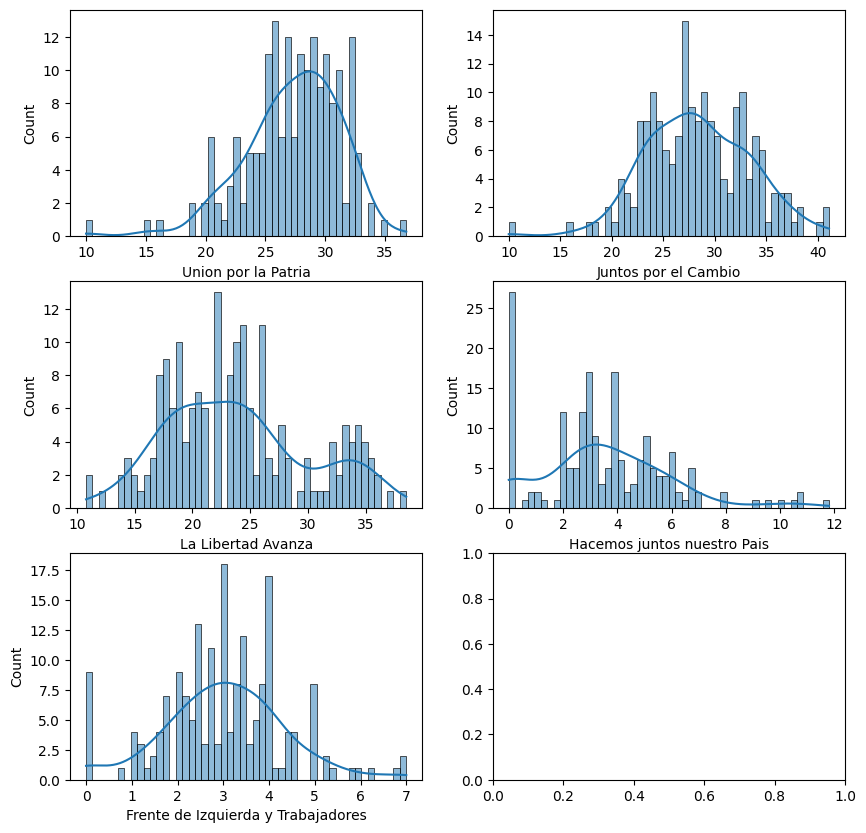

In [107]:
fig, ax = plt.subplots(3,2,figsize=(10,10))
ploteos = ax.flatten()
for i,p in enumerate(partidos):
    sns.histplot(df[p],bins=50, kde=True,ax= ploteos[i])

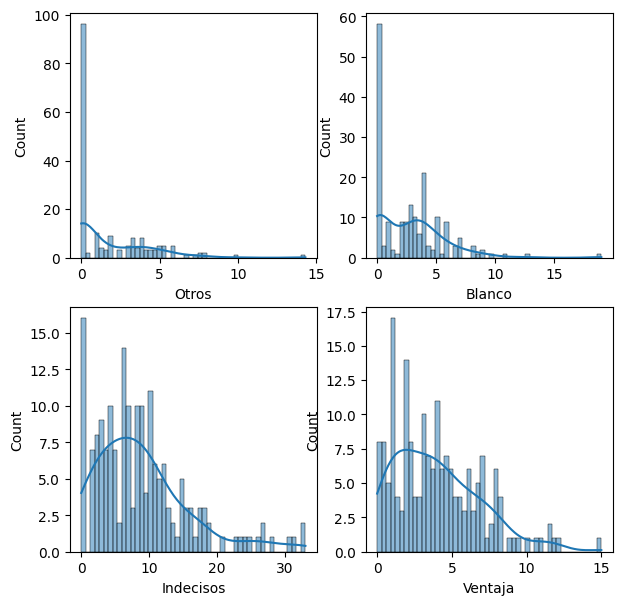

In [108]:
otros = ['Otros', 'Blanco', 'Indecisos', 'Ventaja']
fig, ax = plt.subplots(2,2,figsize=(7,7))
ploteos = ax.flatten()
for i,p in enumerate(otros):
    sns.histplot(df[p],bins=50, kde=True,ax= ploteos[i])

<Axes: xlabel='Muestra', ylabel='Count'>

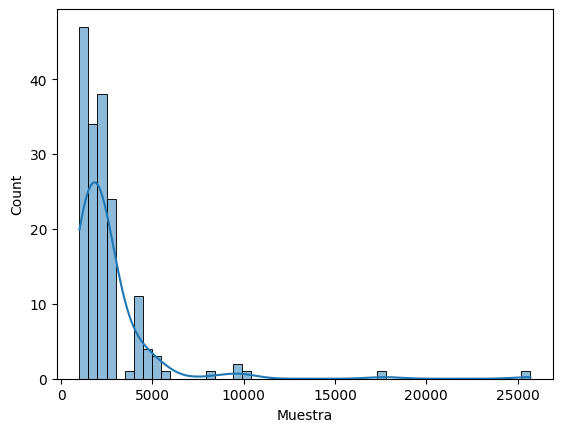

In [109]:
sin_outliers = df[(df['Muestra']<30000) & (df['Muestra']>0)]['Muestra']
sns.histplot(sin_outliers,bins=50, kde=True)

<Axes: ylabel='Count'>

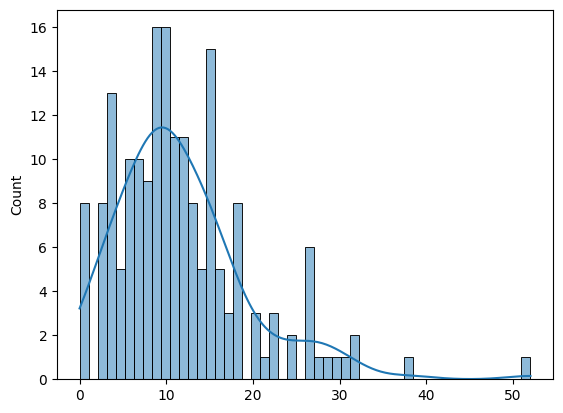

In [12]:
tibios = df['Indecisos']+df['Blanco']
sns.histplot(tibios,bins=50, kde=True)

In [13]:
tibios.quantile(0.90)

22.080000000000005

Filtremos los tibios con la cobertura del 90% de los datos

In [13]:
df  = df.loc[tibios<22]

IDEA  :Dejar los valores de las encuestas en una sola columna, hay que eliminar aquellos que son '-' (DESCARTADO)

In [33]:
# Guardo solo las columas que me interesan
columnas = partidos + ['Inicio', 'Final']
clean = df.loc[:,columnas]
clean.to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/getting_data/encuestas/Encuestas_clean.csv',
             index= False)

# Agreguemos encuestas despues de la primera vuelta

In [9]:
URL = "https://es.wikipedia.org/wiki/Anexo:Encuestas_de_intenci%C3%B3n_de_voto_para_las_elecciones_presidenciales_de_Argentina_de_2023#Tras_la_primera_vuelta"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [10]:
t = soup.find_all('table')[6]

In [14]:
encabezado = ['Fecha', 'Encuestadora','Muestra','La Libertad Avanza', 'Union por la Patria','Blanco','Indecisos','Ventaja']

In [15]:
primera_vuelta= obtener_DF(t,encabezado)


Lo agregamos junto con el otro, pero son los partidos del ballotaje

In [34]:
labels = ['La Libertad Avanza','Union por la Patria','Inicio','Final']
primera_vuelta_clean = primera_vuelta[labels]
clean_ballotaje = clean[labels]
df_ballotaje = pd.concat([primera_vuelta_clean,clean_ballotaje])

In [36]:
df_ballotaje.drop_duplicates().to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/getting_data/encuestas/Encuestas_ballotaje.csv',
             index= False)

Quizas conviene guardarlo por separado

In [44]:
primera_vuelta.dropna(inplace=True)

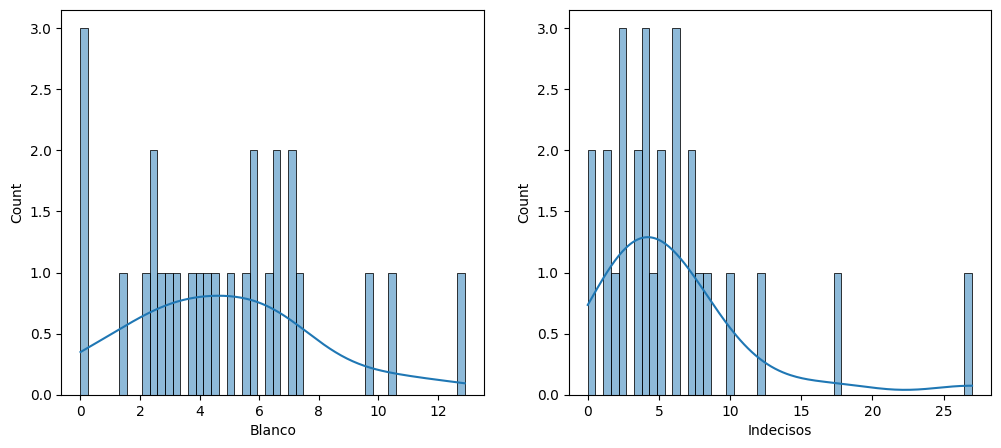

In [72]:
otros = ['Blanco', 'Indecisos']
fig, ax = plt.subplots(1,2,figsize=(12,5))
ploteos = ax.flatten()
for i,p in enumerate(otros):
    sns.histplot(primera_vuelta[p],bins=50, kde=True,ax= ploteos[i])

In [17]:
primera_vuelta = primera_vuelta[primera_vuelta['Indecisos']<20]

In [20]:
labelss = ['La Libertad Avanza','Union por la Patria','Inicio','Final']

In [21]:
primera_vuelta = primera_vuelta[labelss]

In [23]:
primera_vuelta.drop_duplicates().to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/getting_data/encuestas/Encuestas_solo_ballotaje.csv',
             index= False)

# Algunos ploteos

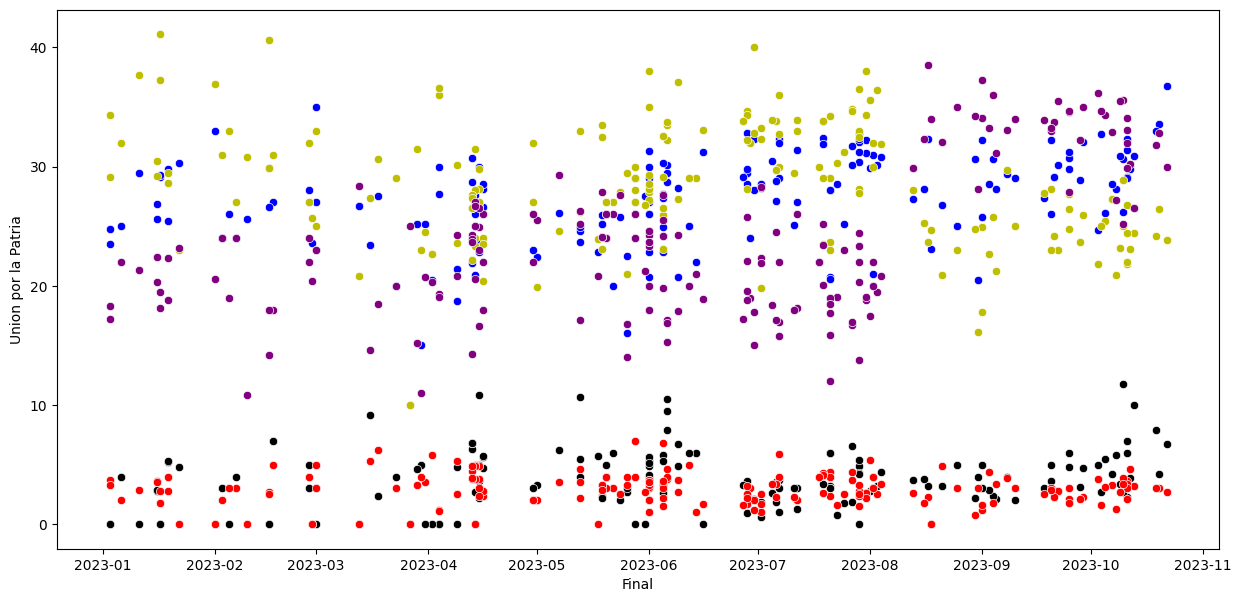

In [95]:
#fig, ax = plt.subplots(5,1, figsize=(12,15))
#ploteos = ax.flatten()
colores = ['b','y','purple','black','r']
plt.figure(figsize=(15,7))
for i,p in enumerate(partidos):
    sns.scatterplot(data=df,y=p,x='Final', 
                    #ax=ploteos[i],
                    color=colores[i])


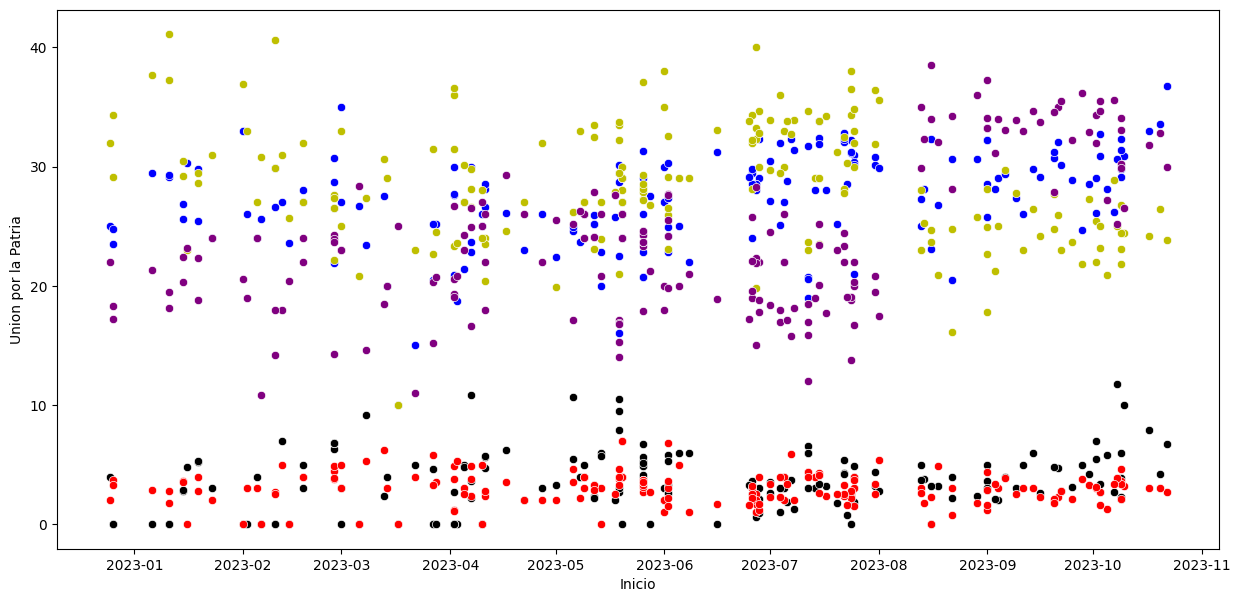

In [96]:
colores = ['b','y','purple','black','r']
plt.figure(figsize=(15,7))
for i,p in enumerate(partidos):
    sns.scatterplot(data=df,y=p,x='Inicio', 
                    #ax=ploteos[i],
                    color=colores[i])
